### HIPPOCORPUS analysis and comparison

#### Score HIPPOCORPUS data and plot

In [1]:
import os, json, time
import pandas as pd
import openai
from scipy.stats import f_oneway, ttest_rel, ttest_ind
import matplotlib.pyplot as plt

k = # ADD YOUR OPENAI API KEY
client = openai.OpenAI(api_key=k)

SYSTEM_PROMPT = """Your task is score text on three metrics: how concrete (vs abstract) it is, how rich in detail it is, and how specific (vs general) it is.

Return ONLY a JSON dictionary with 3 keys, each a float 0-1:

{
  "concrete_vs_abstract": 0-1,
  "rich_vs_poor_details": 0-1,
  "specific_vs_general":  0-1
}

A higher score corresponds to more concrete, richer in detail, or more specific text."""

def llm_scores(text: str,
               model: str = "gpt-4o-mini",
               max_retries: int = 5) -> dict:
    msgs = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": text[:16_000]}
    ]
    for attempt in range(max_retries):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=msgs,
                temperature=0.0,
                response_format={"type": "json_object"},
            )
            return json.loads(resp.choices[0].message.content)
        except openai.RateLimitError:
            time.sleep(2 + attempt)          # back-off then retry
        except openai.OpenAIError as e:
            print("OpenAI error:", e)
            time.sleep(3)
    # if still failing:
    return {"concrete_vs_abstract": None,
            "rich_vs_poor_details": None,
            "specific_vs_general":  None}



In [2]:
df = pd.read_csv("hippoCorpusV2.csv")
stories = (
    df[["recAgnPairId", "memType", "story"]]
      .dropna(subset=["story"])
      .reset_index(drop=True)
)

# records = []
# for row in stories.itertuples(index=False):
#     js = llm_scores(row.story)
#     js.update({"recAgnPairId": row.recAgnPairId,
#                "memType":      row.memType})
#     records.append(js)

# score_df = pd.DataFrame(records)
# score_df.to_csv("story_llm_ratings.csv", index=False)
# print("Saved → story_llm_ratings.csv")

/tmp/ipykernel_2996003/1833566196.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=20)
/tmp/ipykernel_2996003/1833566196.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=20)
/tmp/ipykernel_2996003/1833566196.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=20)


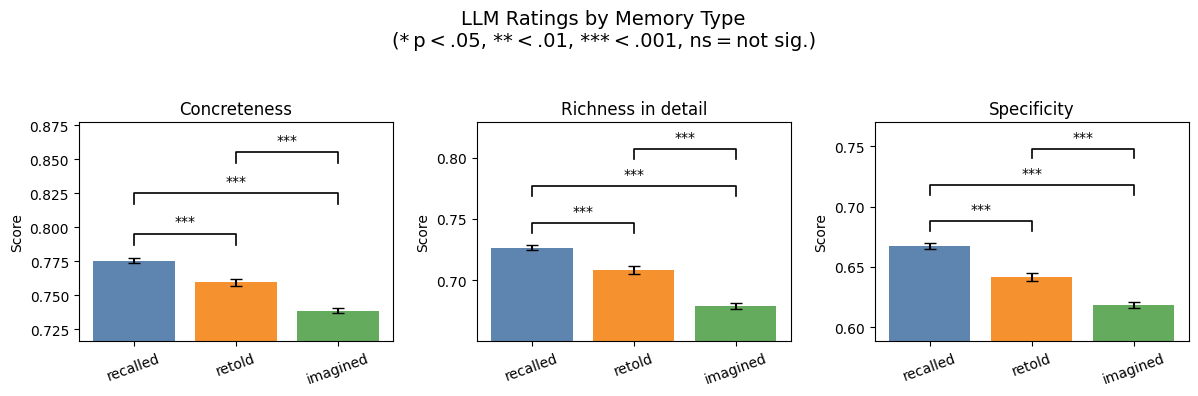

In [3]:
# Load the scores produced earlier
df = pd.read_csv("story_llm_ratings.csv")

metrics = [
    ("concrete_vs_abstract", "Concreteness"),
    ("rich_vs_poor_details", "Richness in detail"),
    ("specific_vs_general",  "Specificity")
]
groups = ["recalled", "retold", "imagined"]
colors = ["#4C78A8", "#F58518", "#54A24B"]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

for ax, (col, title) in zip(axes, metrics):
    # means & SEMs
    means = df.groupby("memType")[col].mean().reindex(groups)
    sems  = df.groupby("memType")[col].sem().reindex(groups)

    # dynamic limits
    y_min_data = (means - sems).min()
    y_max_data = (means + sems).max()

    low_pad  = 0.5 * (y_max_data - y_min_data)          # 5 % padding
    base_sig = y_max_data + 0.01                         # where the 1st line sits
    step     = 0.03                                      # vertical gap per line
    n_pairs  = 3
    y_top    = base_sig + step * (n_pairs - 1) + 0.03   # top of axis

    ax.set_ylim(y_min_data - low_pad, y_top)

    # plot bars -------------------------------------------------------
    ax.bar(groups, means, yerr=sems, color=colors, capsize=4, alpha=.9)
    ax.set_title(title)
    ax.set_ylabel("Score")
    ax.set_xticklabels(groups, rotation=20)

    # pairwise significance lines ------------------------------------
    comparisons = [("recalled","retold"),
                   ("recalled","imagined"),
                   ("retold","imagined")]

    for i, (g1, g2) in enumerate(comparisons):
        x1, x2 = groups.index(g1), groups.index(g2)
        y  = base_sig + i * step
        g1v = df[df.memType==g1][col].dropna()
        g2v = df[df.memType==g2][col].dropna()
        t, p = ttest_ind(g1v, g2v, equal_var=False)

        sym = "***" if p<.001 else "**" if p<.01 else "*" if p<.05 else "ns"
        ax.plot([x1, x1, x2, x2], [y, y+0.008, y+0.008, y], lw=1.2, c="k")
        ax.text((x1+x2)/2, y+0.012, sym, ha="center", va="bottom")


fig.suptitle("LLM Ratings by Memory Type\n(* p < .05, ** < .01, *** < .001, ns = not sig.)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])


#### Plot data from simulations

/tmp/ipykernel_2996003/2569552441.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=20)
/tmp/ipykernel_2996003/2569552441.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=20)
/tmp/ipykernel_2996003/2569552441.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=20)
/tmp/ipykernel_2996003/2569552441.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(groups, rotation=20)


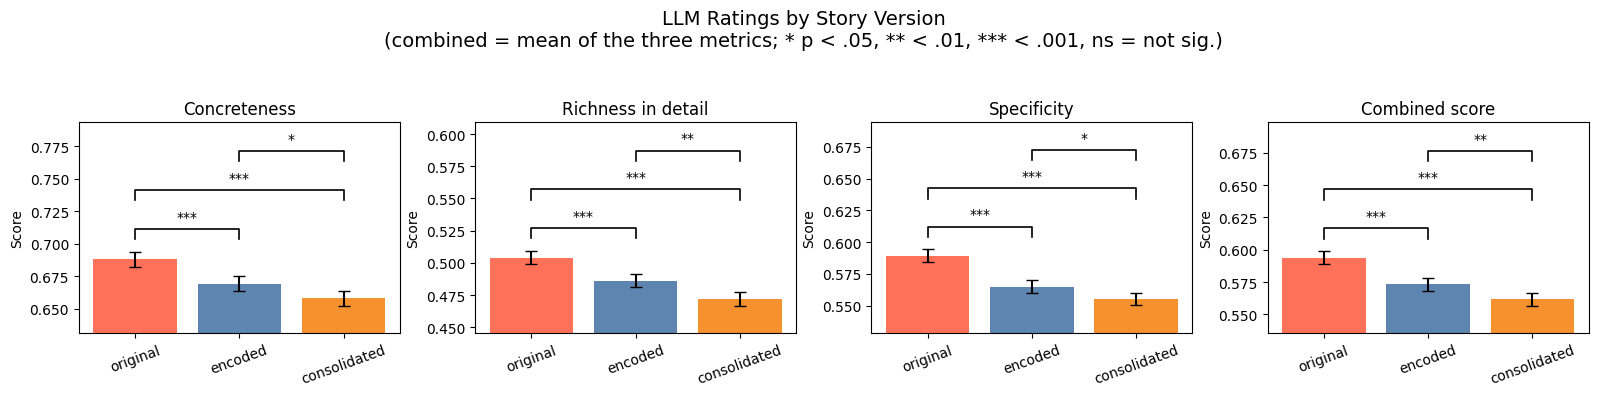

In [4]:
ratings_df = pd.read_csv("output/data/story_llm_ratings_simulated.csv")

# ── existing metrics list ─────────────────────────────────────────
metrics = [
    ("concrete_vs_abstract", "Concreteness"),
    ("rich_vs_poor_details", "Richness in detail"),
    ("specific_vs_general",  "Specificity")
]

metric_cols              = [m[0] for m in metrics]
ratings_df["combined"]   = ratings_df[metric_cols].mean(axis=1)
metrics.append(("combined", "Combined score"))

groups  = ["original", "encoded", "consolidated"]
colors  = ["#4C78A8", "#F58518", "#54A24B"]
colors = ['tomato', "#4C78A8", "#F58518"]
n_plots = len(metrics)

fig, axes = plt.subplots(1, n_plots, figsize=(4 * n_plots, 4), sharey=False)

for ax, (col, title) in zip(axes, metrics):

    # means, SEMs, y-limits (same as before)
    means = ratings_df.groupby("version")[col].mean().reindex(groups)
    sems  = ratings_df.groupby("version")[col].sem().reindex(groups)

    y_min_data = (means - sems).min()
    y_max_data = (means + sems).max()
    low_pad  = 0.5 * (y_max_data - y_min_data)
    base_sig = y_max_data + 0.01
    step     = 0.03
    n_pairs  = 3
    y_top    = base_sig + step * (n_pairs - 1) + 0.03
    ax.set_ylim(y_min_data - low_pad, y_top)

    # bars
    ax.bar(groups, means, yerr=sems,
           color=colors, capsize=4, alpha=.9)
    ax.set_title(title)
    ax.set_ylabel("Score")
    ax.set_xticklabels(groups, rotation=20)

    # pairwise significance lines
    comparisons = [("original", "encoded"),
                   ("original", "consolidated"),
                   ("encoded",  "consolidated")]

    for i, (g1, g2) in enumerate(comparisons):
        x1, x2 = groups.index(g1), groups.index(g2)
        y  = base_sig + i * step
        g1v = ratings_df.loc[ratings_df.version == g1, col].dropna()
        g2v = ratings_df.loc[ratings_df.version == g2, col].dropna()
        t, p = ttest_rel(g1v, g2v, nan_policy='omit')

        sym = "***" if p < .001 else "**" if p < .01 else "*" if p < .05 else "ns"
        ax.plot([x1, x1, x2, x2], [y, y+0.008, y+0.008, y], lw=1.2, c="k")
        ax.text((x1+x2)/2, y+0.012, sym, ha="center", va="bottom", fontsize=10)

fig.suptitle("LLM Ratings by Story Version\n"
             "(combined = mean of the three metrics; * p < .05, ** < .01, *** < .001, ns = not sig.)",
             fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
